In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
import sklearn.linear_model

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer


## Task 1: Univariate Data Analysis for Data Quality Improvement

### Dataset
**This dataset is about forest fires in the Montesinho park in Portugal.** 

It contains meteorological data and other information that can be used to predict a fire in a certain area.

The dataset has 517 instances with 13 attributes. 

<details>
<summary>The features include:</summary>

- X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
- Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
- month - month of the year: "jan" to "dec" 
- day - day of the week: "mon" to "sun"
- FFMC - FFMC index from the FWI system: 18.7 to 96.20
- DMC - DMC index from the FWI system: 1.1 to 291.3 
- DC - DC index from the FWI system: 7.9 to 860.6 
- ISI - ISI index from the FWI system: 0.0 to 56.10
- temp - temperature in Celsius degrees: 2.2 to 33.30
- RH - relative humidity in %: 15.0 to 100
- wind - wind speed in km/h: 0.40 to 9.40 
- rain - outside rain in mm/m2 : 0.0 to 6.4 
- area - the burned area of the forest (in ha): 0.00 to 1090.84 

    this output variable is very skewed towards 0.0, thus it may make
    sense to model with the logarithm transform. 
</details>

[Source](https://www.kaggle.com/datasets/anitarostami/montesinho-forest-fire-prediction-dataset)

In [2]:
df = pd.read_csv('forestfires.csv')
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


Dataset imperfections:
* Skewed distributions ✅  

* Outliers ✅

* Missing values ❌

* Potential noise and data entry errors ❌

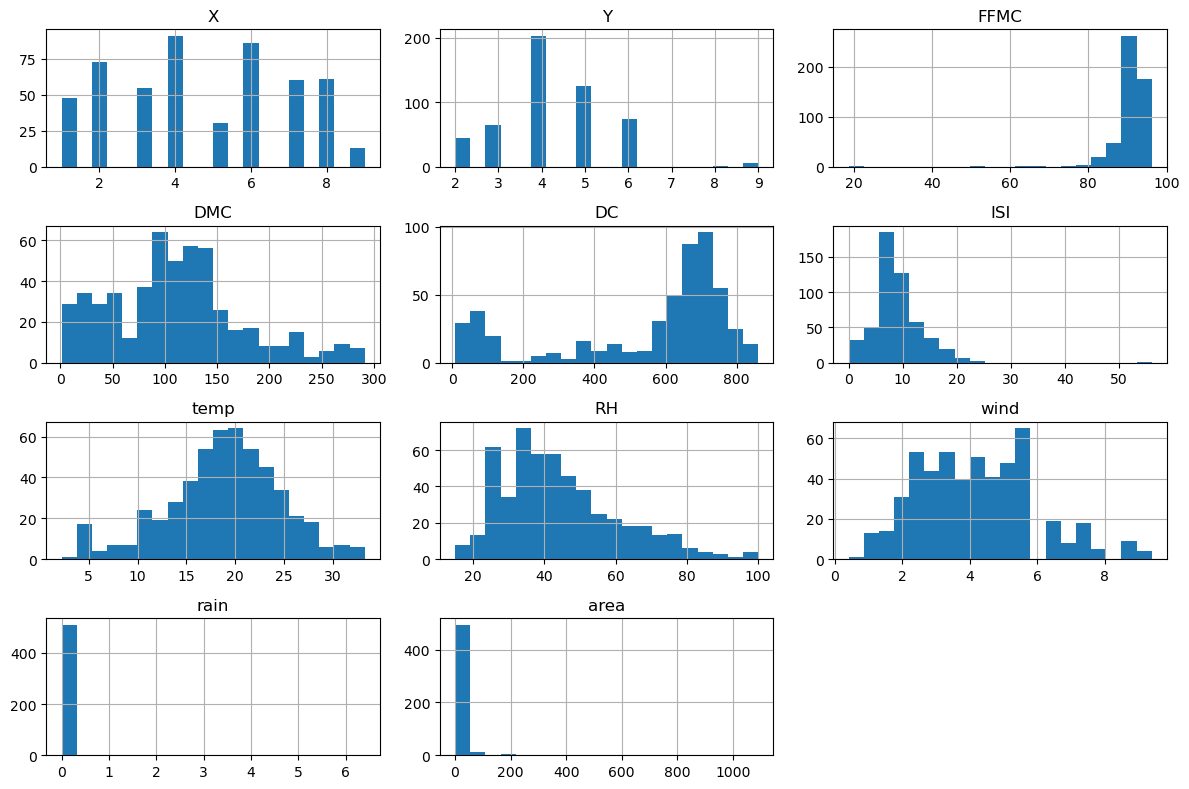

In [3]:
df.hist(figsize=(12, 8), bins=20)
plt.tight_layout()
plt.show()

## Baseline

In [4]:
features = ['X', 'Y', 'FFMC', 'DMC', 'DC', 
            'ISI', 'temp', 'RH', 'wind', 'rain']

X = df[features]
y = df['area']

linear_model = Pipeline([
    ('regressor', sklearn.linear_model.LinearRegression())
])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linear_model.fit(X_train, y_train)
y_pred= linear_model.predict(X_test)

baseline_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
baseline_r2 = r2_score(y_test, y_pred)
print("RMSE:", baseline_rmse)
print("R2:", baseline_r2)

RMSE: 108.44326908355774
R2: 0.0023600333037148147


## Preprocessing

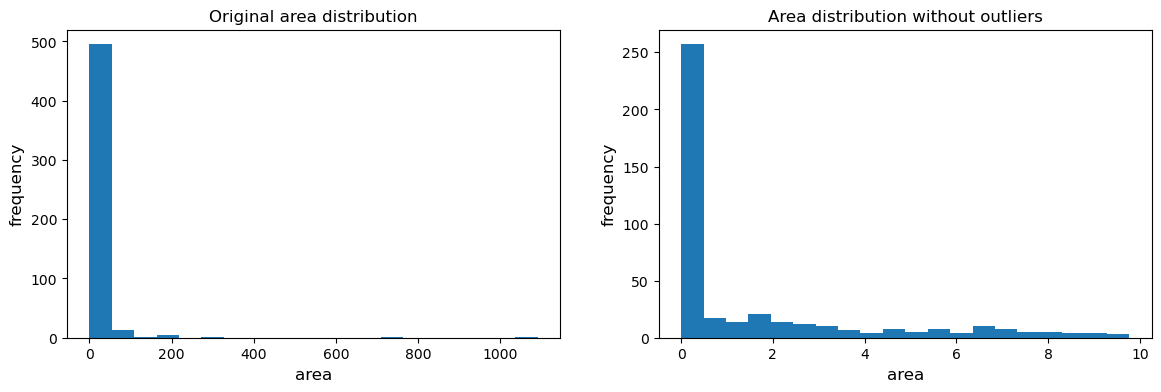

In [5]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.hist(df['area'], bins = 20)
plt.title('Original area distribution')
plt.xlabel('area', fontsize = 12)
plt.ylabel('frequency', fontsize = 12)

plt.subplot(1,2,2)
plt.hist(df[df['area'] <= 1.5 * df['area'].quantile(.75)]['area'], bins = 20)
plt.title('Area distribution without outliers')
plt.xlabel('area', fontsize = 12)
plt.ylabel('frequency', fontsize = 12)
plt.show()

In [6]:
from scipy.stats.mstats import winsorize
df['ISI_capped'] = winsorize(df['ISI'], limits=[0.01, 0.01])

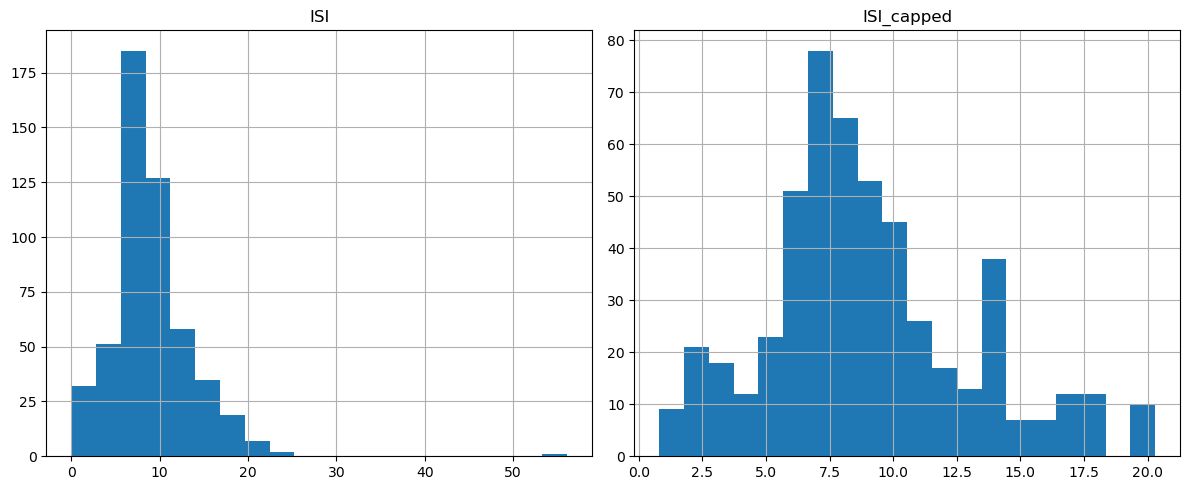

In [7]:
df[["ISI", "ISI_capped"]].hist(figsize=(12, 5), bins=20)
plt.tight_layout()
plt.show()

In [8]:
df = df.drop(['ISI'], axis=1)

In [9]:
cat_vars = ['month', 'day']
num_vars = [col for col in df.columns if col not in cat_vars]

In [10]:
from scipy.stats import skew, kurtosis

def descriptive_stats(df):
    stats = pd.DataFrame(index=df.columns)

    stats['Mean'] = df.mean()
    stats['Median'] = df.median()
    stats['Std Dev'] = df.std()
    stats['Min'] = df.min()
    stats['Max'] = df.max()
    stats['Range'] = df.max() - df.min()
    stats['Q1'] = df.quantile(0.25)
    stats['Q3'] = df.quantile(0.75)
    stats['Skewness'] = df.apply(skew)
    stats['Kurtosis'] = df.apply(kurtosis)

    return stats

result = pd.DataFrame(descriptive_stats(df[num_vars]))
display(result)

,Mean,Median,Std Dev,Min,Max,Range,Q1,Q3,Skewness,Kurtosis
X,4.669246,4.00,2.313778,1.0,9.00,8.00,3.0,7.00,0.036141,-1.172607
Y,4.299807,4.00,1.229900,2.0,9.00,7.00,4.0,5.00,0.416085,1.395269
FFMC,90.644681,91.60,5.520111,18.7,96.20,77.50,90.2,92.90,-6.556512,66.407604
DMC,110.872340,108.30,64.046482,1.1,291.30,290.20,68.6,142.40,0.545908,0.191263
DC,547.940039,664.20,248.066192,7.9,860.60,852.70,437.7,713.90,-1.097250,-0.254461
temp,18.889168,19.30,5.806625,2.2,33.30,31.10,15.5,22.80,-0.330211,0.123269
RH,44.288201,42.00,16.317469,15.0,100.00,85.00,33.0,53.00,0.860398,0.422374
wind,4.017602,4.00,1.791653,0.4,9.40,9.00,2.7,4.90,0.569343,0.042217
rain,0.021663,0.00,0.295959,0.0,6.40,6.40,0.0,0.00,19.758803,417.220970
area,12.847292,0.52,63.655818,0.0,1090.84,1090.84,0.0,6.57,12.809630,192.256646


In [11]:
df['rain_binary'] = (df['rain'] > 0).astype(int)
df['rain_sqrt'] = np.sqrt(df['rain'])
df['FFMC_transformed'] = np.log1p(df['FFMC'].max() + 1 - df['FFMC'])
df['DC_log'] = np.log1p(df['DC'])

In [12]:
display(pd.DataFrame(descriptive_stats(df[['rain_binary', 'rain', 'rain_sqrt', 'FFMC', 'FFMC_transformed', 'DC', 'DC_log']])))

,Mean,Median,Std Dev,Min,Max,Range,Q1,Q3,Skewness,Kurtosis
rain_binary,0.015474,0.000000,0.123547,0.000000,1.000000,1.000000,0.000000,0.000000,7.851160,59.640717
rain,0.021663,0.000000,0.295959,0.000000,6.400000,6.400000,0.000000,0.000000,19.758803,417.220970
rain_sqrt,0.015530,0.000000,0.146505,0.000000,2.529822,2.529822,0.000000,0.000000,12.456581,183.166692
FFMC,90.644681,91.600000,5.520111,18.700000,96.200000,77.500000,90.200000,92.900000,-6.556512,66.407604
FFMC_transformed,1.894475,1.887070,0.464909,0.693147,4.375757,3.682610,1.667707,2.079442,0.713736,3.173430
DC,547.940039,664.200000,248.066192,7.900000,860.600000,852.700000,437.700000,713.900000,-1.097250,-0.254461
DC_log,6.041721,6.500088,0.957204,2.186051,6.758791,4.572740,6.083816,6.572143,-1.863774,2.378411


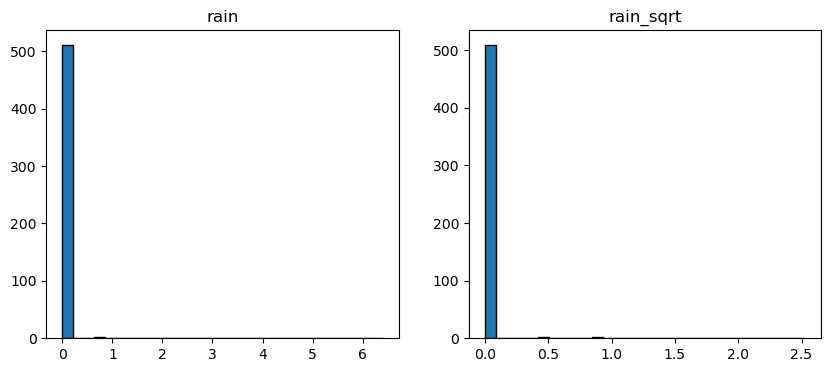

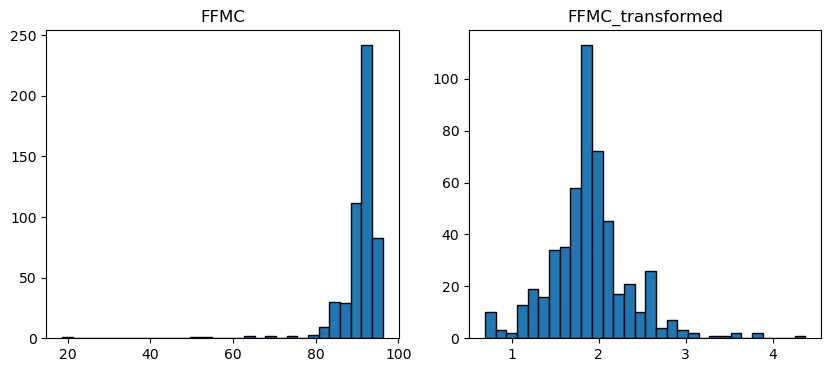

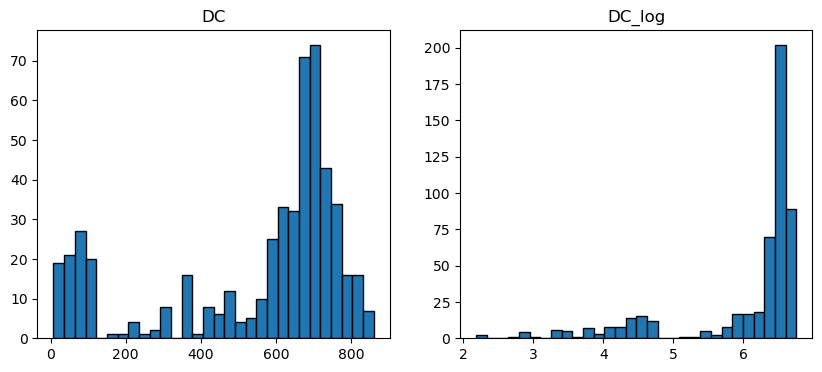

In [13]:
cols_original = ['rain', 'FFMC', 'DC']
cols_transformed = ['rain_sqrt', 'FFMC_transformed', 'DC_log']

for orig, trans in zip(cols_original, cols_transformed):
    plt.figure(figsize=(10,4))
    
    plt.subplot(1,2,1)
    plt.hist(df[orig], bins=30, edgecolor='black')
    plt.title(f"{orig}")
    
    plt.subplot(1,2,2)
    plt.hist(df[trans], bins=30, edgecolor='black')
    plt.title(f"{trans}")
    
    plt.show()

### Model with outliers in area

In [14]:
features = ['X', 'Y', 'month', 'day', 'FFMC_transformed', 'DMC', 'DC', 
            'ISI_capped', 'temp', 'RH', 'wind', 'rain_sqrt', 'rain_binary']

X = df[features]
y = df['area']  # или просто df['area'], если не хотите лог

# Кодируем категориальные
categorical = ['month', 'day']
numerical = [col for col in features if col not in categorical]

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical),
    ('num', StandardScaler(), numerical)
])

linear_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', sklearn.linear_model.LinearRegression())
])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linear_model.fit(X_train, y_train)
y_pred = linear_model.predict(X_test)

model2_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
model2_r2 = r2_score(y_test, y_pred)

### Model without outliers in area

In [15]:
features = ['X', 'Y', 'month', 'day', 'FFMC_transformed', 'DMC', 'DC', 
            'ISI_capped', 'temp', 'RH', 'wind', 'rain_sqrt', 'rain_binary']

df_without_outliers = df[df['area'] < 1.5 * df['area'].quantile(.75)]

X = df_without_outliers[features]
y = df_without_outliers['area']

# Кодируем категориальные
categorical = ['month', 'day']
numerical = [col for col in features if col not in categorical]

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical),
    ('num', StandardScaler(), numerical)
])

linear_model_without_outliers = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', sklearn.linear_model.LinearRegression())
])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linear_model_without_outliers.fit(X_train, y_train)
y_pred = linear_model_without_outliers.predict(X_test)

model3_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
model3_r2 = r2_score(y_test, y_pred)

### Results

In [16]:
metrics_df = pd.DataFrame({
    'Model': ['Baseline', 'Preprocessed (with outliers in area)', 'Preprocessed (without outliers using IQR)'],
    'RMSE': [baseline_rmse, model2_rmse, model3_rmse],
    'R2': [baseline_r2, model2_r2, model3_r2]
})

metrics_df = metrics_df.round(5)

display(metrics_df)

,Model,RMSE,R2
0,Baseline,108.44327,0.00236
1,Preprocessed (with outliers in area),107.79959,0.01417
2,Preprocessed (without outliers using IQR),2.25513,0.00339


### How does the model deal with outliers?

In [17]:
df_outliers = df[df['area'] >= 1.5 * df['area'].quantile(.75)]
X_outliers = df_outliers[features]
y_outliers = df_outliers['area']

In [18]:
y_pred_outliers = linear_model_without_outliers.predict(X_outliers)
linear_without_outliers_rmse = np.sqrt(mean_squared_error(y_outliers, y_pred_outliers))
linear_without_outliers_r2 = r2_score(y_outliers, y_pred_outliers)

print('Score on outliers | Model trained without it')
print('RMSE :', linear_without_outliers_rmse)
print('R2 :', linear_without_outliers_r2)

Score on outliers | Model trained without it
RMSE : 148.96389339418286
R2 : -0.1952659156814207


In [20]:
y_pred_outliers = linear_model.predict(X_outliers)
linear_with_outliers_rmse = np.sqrt(mean_squared_error(y_outliers, y_pred_outliers))
linear_with_outliers_r2 = r2_score(y_outliers, y_pred_outliers)

print('Score on outliers | Model trained with outliers')
print('RMSE :', linear_with_outliers_rmse)
print('R2 :', linear_with_outliers_r2)

Score on outliers | Model trained with outliers
RMSE : 141.64116474464578
R2 : -0.08064110898959664


## Classification $\rightarrow$ Regression 
#### Unsuccessfull experiments

### Global test

In [357]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Classify

In [358]:
from sklearn import metrics

def classification_metrics(estimator, X_test, y_test, name, threshold=None):
    y_proba = estimator.predict_proba(X_test)[:, 1]
    if not threshold:
        y_pred = estimator.predict(X_test)
    else:
        y_pred = (y_proba >= threshold).astype(int)
        
    accuracy = round(metrics.accuracy_score(y_test, y_pred), 4)
    recall = round(metrics.recall_score(y_test, y_pred), 4)
    precision = round(metrics.precision_score(y_test, y_pred), 4)
    f1 = round(metrics.f1_score(y_test, y_pred), 4)
    log_loss = round(metrics.log_loss(y_test, y_proba), 2)

    return [name, accuracy, precision, recall, f1, log_loss]

In [359]:
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical),
    ('num', StandardScaler(), numerical)
])
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

y_train_classify = (y_train > 0).astype(int)
y_test_classify = (y_test > 0).astype(int)

In [360]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

rf = RandomForestClassifier(n_estimators=100, random_state=42, criterion='entropy', max_features='log2')
dt = tree.DecisionTreeClassifier(random_state=42)

model = rf
model.fit(X_train, y_train_classify)

,n_estimators,100
,criterion,'entropy'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'log2'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [361]:
y_proba = model.predict_proba(X_test)[:, 1]

thresholds = np.linspace(0, 1, 1000)
best_threshold = 0.5

for threshold in thresholds:
    y_pred_custom = (y_proba >= threshold).astype(int)
    recall = metrics.recall_score(y_test_classify, y_pred_custom)
    if recall >= 0.95:
        best_threshold = threshold

print(f"Threshold for Recall >= 0.95: {best_threshold:.3f}")

Threshold for Recall >= 0.95: 0.159


### Regression

In [362]:
y_train_reset = y_train.reset_index()['area']
y_test_reset = y_test.reset_index()['area']

y_train_reg = y_train_reset[y_train_reset > 0] #.index
y_test_reg = y_test_reset[y_test_reset > 0]

X_train_reg = X_train[y_train_reg.index]
X_test_reg = X_test[y_test_reg.index]

In [363]:
linear_reg = sklearn.linear_model.LinearRegression()
linear_reg.fit(X_train_reg, y_train_reg)

y_pred = linear_reg.predict(X_test_reg)

model2_rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred))
model2_r2 = r2_score(y_test_reg, y_pred)

print(model2_rmse)
print(model2_r2)

2.9558719504287496
-0.13747469347468044


### Final Validation

In [364]:
y_binary_pred = model.predict(X_test)

regression_indices = np.where(y_binary_pred == 1)[0]
y_reg_pred = linear_reg.predict(X_test[regression_indices])

In [365]:
mask = y_binary_pred == 1
y_pred = np.zeros_like(y_binary_pred, dtype=float)
y_pred[mask] = y_reg_pred  # Автоматически распределит по позициям mask=True

In [366]:
model2_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
model2_r2 = r2_score(y_test, y_pred)

print(model2_rmse)
print(model2_r2)

2.434364668034925
-0.16133382855620892


worse than model fitted on data without outliers